#### WP Berechnung nach MA von Nik

Heizlast oder Heizleistung
- Heizlast = spez. Heizlast nach Baujahr * Wohn- bzw. Heizfläche
- Daraus WP Größe
- Q_ab (WP) = Q_zu(Wärmequelle)+ P (elektrische Leistung) 
- COP = Q_ab/P
- Heizkennlinie: Vor-, Rücklauftemp, 
- Heizgrenze: 15°C (DIN V 18599)
- Raumtemperatur, T_soll: 20°C (DIN EN 12831 Beiblatt 2)

Baujahr Annahme: Teilsaniert oder Neubau - Unsaniert nicht betrachtet
- 1977 bis 2008 -> Teilsaniert Altbau - Heizkörper: 55 -> 45
- 2009 bis heute -> gut gedämmt - Fußboden: 35 -> 28

In [ ]:
# spez. Heizlast nach Baujahr - csv Datei
# Quelle: https://www.heizung.de/ratgeber/diverses/heizlastberechnung-zur-bestimmung-der-heizleistung.html
import pandas as pd 

s_heizlast = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\spez_Heizlast.xlsx')
s_heizlast.set_index('Fläche', inplace=True)
s_heizlast

,ab 2009,2002-2008,1995-2001,1984-1994,1978-1983,bis 1977
Fläche,,,,,,
100,38,45,67,99,115,163
125,38,45,67,98,114,162
150,37,44,66,98,114,161
200,37,44,65,97,113,160
300,36,43,64,95,110,157
500,33,40,60,90,105,150


In [41]:
# Heizlast berechnen
# beide sollen als drop-down abgefragt werden!
wohnflaeche = 125
baujahr = 'ab 2009'
plz = 40599

heizlast = wohnflaeche*s_heizlast.loc[wohnflaeche, baujahr]
print("Heizleistung ist [kW]: ", heizlast/1000)

Heizleistung ist [kW]:  4.75


In [ ]:
# Norm-Außentemperatur/Auslegungsaußentemperatur aus DIN/TS 12831-1
# mit PLZ
klimadaten = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\DINTS_12831-1_Klimadaten\\Klimadaten.xlsx')

naechste_plz = None
kleinster_abstand = float('inf')  # Setze den anfänglichen Abstand auf unendlich
T_n_aussen = None

for index, row in klimadaten.iterrows():
    abstand = abs(row['PLZ'] - plz)  # Absoluter Unterschied zwischen PLZ
    if abstand < kleinster_abstand:  # Prüfen, ob der aktuelle Abstand kleiner ist
        kleinster_abstand = abstand
        naechste_plz = row['PLZ']
        T_n_aussen = row['Auslegungsaußentemperatur']

print(f"Die nächste PLZ zu {plz} ist {naechste_plz} mit einer Auslegungsaußentemperatur von {T_n_aussen}°C.")

Die nächste PLZ zu 40599 ist 40599 mit einer Auslegungsaußentemperatur von -7.8°C.


Heizkurve Parameter (wie Nik und Buch Heße, 2020)
- Norm-Vorlauftemperatur: T_n_vor = 55 oder 35 (Annahme)
- Norm Rücklauftemperatur: T_n_rueck = 45 oder 27 (Annahme)
- Norm-Außentemperatur: T_n_aussen = klimadaten
- Raumztemperatur: T_soll = 20 (Annahme)
- Heizflächenexponent: p = 1,1 Fußboden oder 1,3 Radiatoren/Niedertemperaturheizkörper (Annahme)
- mittlere Übertemperatur Normzustand: T_m_n_ueber = (T_vor - T_rueck)/ln(T_vor-T_soll)/(T_rueck-T_soll)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# T_aussen + Datum
heizkennlinie = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\T_amb_40599_2016.csv')

if baujahr == ('ab 2009'):
    art = 'Fußbodenheizung'
    T_n_vor = 35
    T_n_rueck = 28
    T_soll = 20
    p = 1.1
    T_m_n_ueber = (T_n_vor-T_n_rueck)/(np.log((T_n_vor-T_soll)/(T_n_rueck-T_soll)))
else:
    art = 'Heizkörper'
    T_n_vor = 55
    T_n_rueck = 45
    T_soll = 20
    p = 1.3
    T_m_n_ueber = (T_n_vor-T_n_rueck)/(np.log((T_n_vor-T_soll)/(T_n_rueck-T_soll)))

# Lastverhältnis phi
heizkennlinie['Lastverhältnis'] = np.divide(T_soll-heizkennlinie['temp'], T_soll-T_n_aussen)

#e^x
heizkennlinie['e^x'] = np.exp(np.divide((heizkennlinie['Lastverhältnis']**(p-1/p))*(T_n_vor-T_n_rueck), T_m_n_ueber))

# Vorlauftemperatur: T_vor [°C]
heizkennlinie['T_vor'] = np.divide(heizkennlinie['e^x']*((T_n_vor-T_n_rueck)*heizkennlinie['Lastverhältnis']+T_soll)-T_soll, heizkennlinie['e^x']-1)

# Rücklauftemperatur: T_rueck [°C]
heizkennlinie['T_rueck'] = heizkennlinie['T_vor']-heizkennlinie['Lastverhältnis']*(T_n_vor-T_n_rueck)

heizkennlinie

,time,temp,T_vorlauf,Lastverhältnis,e^x,T_vor,T_rueck
0,2016-01-01 00:00:00,5.1,29.95,0.535971,1.747257,28.772557,25.020759
1,2016-01-01 01:00:00,4.8,30.10,0.546763,1.750979,28.923803,25.096465
2,2016-01-01 02:00:00,5.1,29.95,0.535971,1.747257,28.772557,25.020759
3,2016-01-01 03:00:00,5.4,29.80,0.525180,1.743483,28.620906,24.944647
4,2016-01-01 04:00:00,5.5,29.75,0.521583,1.742212,28.570264,24.919185
...,...,...,...,...,...,...,...
8779,2016-12-31 19:00:00,1.1,31.95,0.679856,1.793135,30.759222,26.000229
8780,2016-12-31 20:00:00,0.4,32.30,0.705036,1.800445,31.100884,26.165632
8781,2016-12-31 21:00:00,-0.8,32.90,0.748201,1.812565,31.682937,26.445527
8782,2016-12-31 22:00:00,-1.5,33.25,0.773381,1.819412,32.020445,26.606776


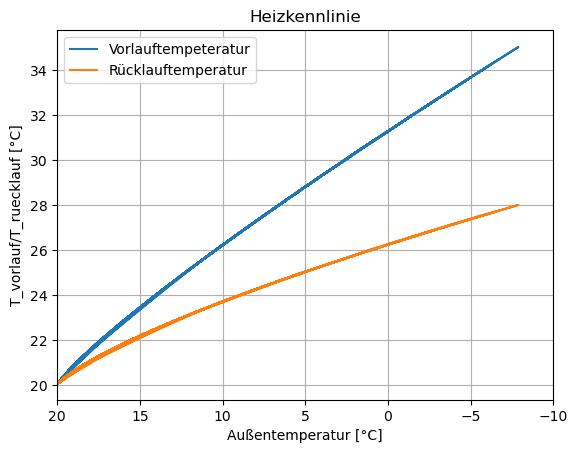

In [37]:
plt.plot(heizkennlinie['temp'], heizkennlinie['T_vor'], label = 'Vorlauftempeteratur')
plt.plot(heizkennlinie['temp'], heizkennlinie['T_rueck'], label = 'Rücklauftemperatur')

plt.xlim(20, -10)
#plt.ylim(30, 60)
plt.xlabel('Außentemperatur [°C]')
plt.ylabel('T_vorlauf/T_ruecklauf [°C]')
plt.title('Heizkennlinie')
plt.grid(True)
plt.legend()
plt.show()